In [16]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [17]:
model = torch.load("logs/criteo/dcn-10/checkpoints/best.pth", map_location="cpu")
model.keys()

odict_keys(['embedding.embedding.weight', 'cn.W.0', 'cn.W.1', 'cn.W.2', 'cn.W.3', 'cn.b.0', 'cn.b.1', 'cn.b.2', 'cn.b.3', 'mlp.mlp.0.weight', 'mlp.mlp.0.bias', 'mlp.mlp.1.weight', 'mlp.mlp.1.bias', 'mlp.mlp.1.running_mean', 'mlp.mlp.1.running_var', 'mlp.mlp.1.num_batches_tracked', 'mlp.mlp.4.weight', 'mlp.mlp.4.bias', 'mlp.mlp.5.weight', 'mlp.mlp.5.bias', 'mlp.mlp.5.running_mean', 'mlp.mlp.5.running_var', 'mlp.mlp.5.num_batches_tracked', 'linear.weight', 'linear.bias'])

In [18]:
embed_dim = model["embedding.embedding.weight"].shape[1]

In [19]:
field_dims = np.array(
[    49,    101,    126,     45,    223,    118,     84,     76,     95,      9,
     30,     40,     75,   1458,    555, 193949, 138801,    306,     19,  11970,
    634,      4,  42646,   5178, 192773,   3175,     27,  11422, 181075,     11,
   4654,   2032,      5, 189657,     18,     16,  59697,     86,  45571,])
field_dims.sum()

1086810

In [20]:
def split_to_field(weight: torch.Tensor):
    return weight.split(tuple(field_dims))

def split_to_field_for_all(weights):
    all_weights = [[] for _ in range(39)]
    for weight in weights:
        splitted_weights = split_to_field(weight)
        for all_weight, splitted_weight in zip(all_weights, splitted_weights):
            all_weight.append(splitted_weight)
    return all_weights

In [21]:
all_weight = split_to_field(model["embedding.embedding.weight"])

In [22]:
def plot_info_map(all_weight, tgt_idx):
    print(field_dims[tgt_idx])
    value = torch.svd(all_weight[tgt_idx]).S
    value /= value.max()
    print(value)
    value = value.unsqueeze(0)
    sns.heatmap(value, vmin=0.0, vmax=1.0, cmap="Reds")
    plt.show()

In [23]:
def plot_info_maps(all_weight, reduce=True):
    value_list = []
    for rank, idx in enumerate(np.argsort(field_dims)):
        emb = all_weight[idx].clone()
        emb /= (emb.norm(p=2, dim=-1, keepdim=True) + 1e-8)
        _value = torch.svd(emb).S
        _value /= _value.max()
        
        value = torch.zeros(embed_dim)
        value[:_value.shape[0]] = _value
        value_list.append(value)
    value_total = torch.stack(value_list, dim=0)
    if reduce:
        return value_total.sum(dim=-1)
    else:
        return value_total

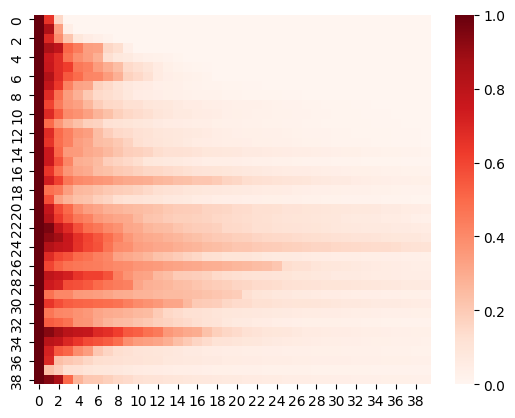

In [24]:
singular_values = plot_info_maps(all_weight, reduce=False)
sns.heatmap(singular_values, cmap="Reds", vmin=0.0, vmax=1.0)
plt.show()

In [25]:
def plot_info_map_after_proj(idx):
    all_weight_after_proj = torch.matmul(model["cn.W.0"][:, embed_dim*idx:embed_dim*(idx+1)], all_weight[idx].unsqueeze(2))  # (len, 390)
    all_weight_after_proj = all_weight_after_proj.reshape(-1, 39, embed_dim).permute(1, 0, 2)
    return plot_info_maps(all_weight_after_proj)

In [26]:
def plot_info_map_after_proj_inv(idx):
    all_weight_after_proj_inv = []
    for i in range(39):
        all_weight_after_proj = torch.matmul(model["cn.W.0"][:, embed_dim*i:embed_dim*(i+1)], all_weight[i].unsqueeze(2)).squeeze(2)[:, embed_dim*idx:embed_dim*(idx+1)]  # (len, 10)
        all_weight_after_proj_inv.append(all_weight_after_proj)
    plot_info_maps(all_weight_after_proj_inv)

In [27]:
plot_info_map_after_proj_inv(23)

In [28]:
iass = []
for idx in np.argsort(field_dims):
    ias = plot_info_map_after_proj(idx)
    iass.append(ias)
iass = torch.stack(iass, dim=0)

In [29]:
raw_ia = plot_info_maps(all_weight)
torch.set_printoptions(threshold=torch.inf)
print(torch.sort(raw_ia)[0])
print(iass[:, np.argsort(raw_ia)][np.argsort(raw_ia), :])

tensor([ 1.8055,  2.2286,  2.4942,  2.9876,  3.8397,  3.8542,  4.3106,  4.3116,
         4.3706,  4.5225,  4.5876,  4.6015,  5.1082,  5.1697,  5.2290,  5.2314,
         5.3409,  5.4200,  5.5282,  5.6482,  6.1838,  6.1951,  6.2679,  6.5558,
         6.8092,  7.9771,  8.3019,  8.5508,  8.7737,  8.8623,  9.7325, 10.0824,
        10.2295, 10.2552, 10.5016, 10.7360, 11.6665, 12.3058, 12.4721])
tensor([[1.0299, 1.7920, 1.8061, 1.7291, 1.5804, 1.6687, 1.4642, 1.6103, 1.8150,
         1.7487, 1.3377, 1.4966, 1.2633, 1.4381, 1.5213, 1.4907, 1.7566, 1.5802,
         1.6222, 1.6793, 1.3676, 1.4052, 1.7738, 1.5644, 1.5514, 1.7776, 1.3928,
         1.3527, 1.3765, 1.8433, 1.4925, 1.3679, 1.6236, 1.5220, 1.4978, 1.7608,
         1.5779, 1.6932, 1.4733],
        [1.5473, 1.2361, 1.6400, 1.6641, 1.9476, 1.7398, 1.5978, 1.8121, 1.7601,
         1.7338, 2.0044, 1.8129, 1.6832, 1.8758, 1.9688, 2.0474, 2.0662, 1.8411,
         1.7810, 1.9162, 1.7829, 1.7405, 1.7240, 1.9608, 1.9337, 2.0414, 2.0178,
       

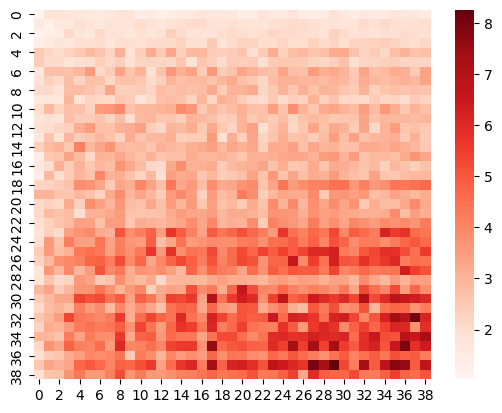

In [30]:

sns.heatmap(iass[:, np.argsort(raw_ia)][np.argsort(raw_ia), :].numpy(), cmap="Reds")
plt.show()